In [37]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import product

figwidth = 6.224
golden_ratio = 1.61803
figsize = (figwidth, figwidth / golden_ratio)
import matplotlib as mpl
# plt.style.use('seaborn-white')
sns.set_style("ticks")
mpl.rcParams['figure.figsize'] = figsize

# PATH = 'C:\\Users\\simon\\PycharmProjects\\covid\\raw_data\\covid_de\\'
p1 = 'C:\\Users\\simon\\Google Drive\\Work\\COVID-19\\data\\kaggle\\'
p2 = 'C:\\Users\\simon\\Google Drive\\Work\\COVID-19\\data\\watts strogatz 2\\'
p3 = 'D:\\covid-modeling\\seir\\random graph\\'

In [38]:
%matplotlib inline

# Simulated cases

In [39]:
n_pr = np.load(p2+'n_pr.npy', allow_pickle=True)
n_pr2 = np.load(p3+'n_pr.npy', allow_pickle=True)
params = np.load(p2+'params.npz')
ps = params['ps']
reps = int(params['reps'])
k_offblock = params['ks']

In [40]:
ps = np.array(list(ps) + [1])
n_pr = np.vstack((n_pr, n_pr2))

In [41]:
tmax = max(map(len, n_pr.flat))  # maximum time of epidemic
n_prnew = np.array([list(xi) + [xi[-1]] * (tmax - len(xi)) for xi in n_pr.ravel()])
n_prnew = n_prnew.reshape((len(ps), len(k_offblock), reps, n_prnew.shape[-2], n_prnew.shape[-1]))

In [42]:
t_lag = 10
nps = len(ps)
nks = len(k_offblock)
n_tot = n_prnew[0, 0, 0, 0].sum()
hcap = n_tot * 30 // 100000
axreps = 2

In [43]:
n_prnew = n_prnew * 1e6 / n_tot

In [44]:
dflist = [pd.DataFrame({'S': n_pr[ip, ik, n][:, 0] * 1e6 / n_tot, 'E': n_pr[ip, ik, n][:, 1] * 1e6 / n_tot,
                        'I': n_pr[ip, ik, n][:, 2] * 1e6 / n_tot, 'R': n_pr[ip, ik, n][:, 3] * 1e6 / n_tot,
                        't': np.arange(n_pr[ip, ik, n].shape[0]), 'k': k, 'p': p, 'n': n, 'id': i})
          for i, ((ip, p), (ik, k), n) in enumerate(product(enumerate(ps), enumerate(k_offblock), range(reps)))]

dfsim = pd.concat(dflist, ignore_index=True)
gb = dfsim.groupby('id')
dfsim['New cases'] = gb.I.diff() + gb.R.diff()
dfsim['New cases'] = dfsim['New cases'].fillna(0)

In [45]:
dfsim = dfsim[dfsim.t < 150]

In [46]:
# del dfsim['Mean new cases']
window = 7
def add_rolling_mean(x):
    x['Rolling new cases'] = x['New cases'].rolling(window, center=True).mean().fillna(0)
    return x

dfsim = dfsim.groupby('id').apply(add_rolling_mean)

In [47]:
def add_shifted_date(x):
    x['Shifted t'] = x.t - x.loc[x['Rolling new cases'] >= 1].t.min()
    return x

dfsim = dfsim.groupby('id').apply(add_shifted_date)

In [48]:
dfsim['Cumulative cases'] = dfsim.groupby('id')['New cases'].cumsum()

In [49]:
def add_R(x, tlag=7):
    active = x['Rolling new cases'].values.astype(float)
    R = np.full_like(active, np.nan)
    R[tlag:] = np.divide(active[tlag:], active[:-tlag], where=active[:-tlag]>0, out=np.full_like(R[tlag:], np.nan))
    x['R'] = R
    return x

dfsim = dfsim.groupby('id').apply(add_R)

In [50]:
df = pd.read_csv(p1+'full_grouped.csv', parse_dates =["Date"])  # dataset from kaggle: https://www.kaggle.com/imdevskp/corona-virus-report

In [51]:
interesting_countries = ['US', 'Italy', 'Germany', 'France', 'United Kingdom', 'Switzerland', 'Austria', 'Sweden',
                         'Russia']
populations = pd.read_csv(p1+'worldometer_data.csv', index_col='Country/Region', sep=';')['Population'] # get info on population from worldometer
df['Country'] = df['Country/Region']
df = df.loc[df['Country/Region'].isin(interesting_countries)].reset_index()

In [52]:
window = 7
for country in interesting_countries:
    pop = populations[country]
    df.loc[df['Country'] == country, 'Active pm'] = df.loc[df['Country'] == country, 'Active'] * 1e6 / pop
    df.loc[df['Country'] == country, 'Confirmed pm'] = df.loc[df['Country'] == country, 'Confirmed'] * 1e6 / pop
    df.loc[df['Country'] == country, 'New cases pm'] = df.loc[df['Country'] == country, 'New cases'] * 1e6 / pop
    df.loc[df['Country'] == country, 'Mean new cases'] = df.loc[df['Country'] == country].rolling(window, on='Date', center=True)['New cases'].mean()
    df.loc[df['Country'] == country, 'Mean new cases pm'] = df.loc[df['Country'] == country].rolling(window, on='Date', center=True)['New cases pm'].mean()
    df.loc[df['Country'] == country, 'Population'] = pop

In [53]:
shifts = df.loc[df['Mean new cases pm'] >= 1].groupby('Country/Region').Date.min()
for name, group in df.groupby('Country/Region'):
    if name in interesting_countries:
        df.loc[df['Country/Region'] == name, 'Shifted Date pm'] = group.Date - shifts[name]

df['Shifted Date pm'] = df['Shifted Date pm'].dt.days

In [54]:
coloredcountries = interesting_countries[:3]
graycountries = interesting_countries[3:]

In [55]:
tlag = 7
df['R'] = df['New cases'] * 0.
for name, group in df.groupby('Country/Region'):
    if name in interesting_countries:
        cases = group['Mean new cases'].values.astype(float)
        R = np.full_like(cases, np.nan, dtype=float)
        R[tlag:] = np.divide(cases[tlag:], cases[:-tlag], where=cases[:-tlag]>0, out=R[tlag:])
        df.loc[df['Country/Region'] == name, 'R'] = R
#         print(active)

In [56]:
from scipy.integrate import solve_ivp
def seir(t, y, b, N=1e6, a=1/3, c=0.1):
    s, e, i, r = y
    ds = -b * i / N * s
    de = b * i / N * s - a * e
    di = a * e - c * i
    dr = c * i
    return np.array([ds, de, di, dr])

ks = [8, 6, 4]
y0 = np.array([1e6-100, 0, 100, 0])
sols = []

for k in ks:
    b = k * 0.02
    s = solve_ivp(seir, (0, 200), y0, t_eval=range(200), args=(b,))
    _, _, i, r = s.y
    nc_ode = np.zeros_like(i)
    nc_ode[1:] = i[1:] - i[:-1] + r[1:] - r[:-1]
    cum_ode = nc_ode.cumsum()
    r_ode = np.full_like(i, np.nan)
    r_ode[tlag:] = np.divide(nc_ode[tlag:], nc_ode[:-tlag], where=nc_ode[:-tlag]>0, out=np.full_like(r_ode[tlag:], np.nan))
    tmin = np.argmax(nc_ode > 1)
    t = np.arange(200) - np.arange(200)[tmin]
    sols.append([t, nc_ode, cum_ode, r_ode])

C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\simon\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


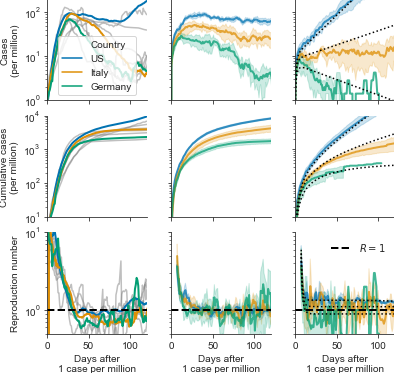

In [58]:
ks_clustered = [14, 12, 10]
w = figwidth
fig, axs = plt.subplots(nrows=3, ncols=3, sharey='row', sharex=True, figsize=(w, 1.6/golden_ratio*w), gridspec_kw={'hspace': 0.15,
                                                                                                                 'wspace': 0.25},
                       tight_layout=True)
### real data
plt.sca(axs[0][0])
# plt.title('Cases (per mil)')
sns.lineplot(data=df.loc[df['Country/Region'].isin(coloredcountries)], x='Shifted Date pm', linewidth=2, palette='colorblind',
            y='Mean new cases pm', hue='Country', hue_order=coloredcountries, estimator=sum, ci=None, legend='brief')
sns.lineplot(data=df.loc[df['Country/Region'].isin(graycountries)], x='Shifted Date pm', palette=['Gray']*len(interesting_countries[3:]),
            alpha=0.5, y='Mean new cases pm', hue='Country', hue_order=graycountries, estimator=sum, ci=None, legend=False, zorder=-1)
plt.ylim(1, 2e2)
plt.ylabel('')
plt.ylabel('Cases\n(per million)')
plt.yscale('log')
sns.despine()


plt.sca(axs[1][0])
# plt.title('Cumulative cases (per mil)')
sns.lineplot(data=df.loc[df['Country/Region'].isin(coloredcountries)], x='Shifted Date pm', y='Confirmed pm', linewidth=2, palette='colorblind',
            hue='Country', hue_order=coloredcountries, estimator=sum, ci=None, legend=False)
sns.lineplot(data=df.loc[df['Country/Region'].isin(graycountries)], x='Shifted Date pm', palette=['Gray']*len(interesting_countries[3:]),
            alpha=0.5, y='Confirmed pm', hue='Country', hue_order=graycountries, estimator=sum, ci=None, legend=False, zorder=-1)
plt.ylabel('Cumulative cases\n(per million)')
# plt.ylabel('')
plt.ylim(1e1, 1e4)
plt.yscale('log')
sns.despine()


plt.sca(axs[2][0])
sns.lineplot(data=df.loc[df['Country/Region'].isin(coloredcountries)], x='Shifted Date pm', y='R', linewidth=2, palette='colorblind',
            hue='Country', hue_order=coloredcountries, estimator=sum, ci=None, legend=False)
sns.lineplot(data=df.loc[df['Country/Region'].isin(graycountries)], x='Shifted Date pm', palette=['Gray']*len(interesting_countries[3:]),
            alpha=0.5, y='R', hue='Country', hue_order=graycountries, estimator=sum, ci=None, legend=False, zorder=-1)
plt.xlim(0, 120)
plt.ylim(0.5, 10)
plt.plot([0, 200], [1, 1], 'k--', label='R = 1', lw=2)
plt.yscale('log')
plt.ylabel('Reproduction number')
plt.xlabel('Days after\n1 case per million')
# plt.ylabel('')

### clustered graph ###
ind = 2
plt.sca(axs[0][1])
sns.despine()
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks_clustered)], hue='k', x='Shifted t', y='Rolling new cases',
             palette='colorblind', hue_order=ks_clustered, # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
sns.despine()


plt.sca(axs[1][1])
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks_clustered)], hue='k', x='Shifted t', y='Cumulative cases',
             palette='colorblind', hue_order=ks_clustered,# style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
# plt.ylabel('')
sns.despine()


plt.sca(axs[2][1])
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks_clustered)], hue='k', x='Shifted t', y='R',
             palette='colorblind', hue_order=ks_clustered,# style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)

plt.plot([0, 200], [1, 1], 'k--', label='R = 1', lw=2)
plt.xlabel('Days after\n1 case per million')
sns.despine()
plt.tight_layout()

### random graph ###
ind = -1
plt.sca(axs[0][2])
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks)], hue='k', x='Shifted t',
             y='Rolling new cases', hue_order=ks,
             palette='colorblind', # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
for sol in sols:
    plt.plot(sol[0], sol[1], 'k:')
sns.despine()

plt.sca(axs[1][2])
# plt.title('Cumulative cases (per mil)')
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks)], hue='k', x='Shifted t',
             y='Cumulative cases', hue_order=ks,
             palette='colorblind', # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
for sol in sols:
    plt.plot(sol[0], sol[2], 'k:')
sns.despine()


plt.sca(axs[2][2])
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks)], hue='k', x='Shifted t', y='R',
             palette='colorblind', hue_order=ks,# style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)

plt.plot([0, 200], [1, 1], 'k--', label='$R = 1$', lw=2)
for sol in sols:
    plt.plot(sol[0], sol[3], 'k:')
plt.xlabel('Days after\n1 case per million')
plt.legend(loc='upper right', frameon=False)
sns.despine()

plt.savefig('figures\\Fig1.svg', bbox_inches='tight', pad_inches=0)

In [59]:
mean_infected = n_prnew[..., 2].mean(axreps)
std_infected = n_prnew[..., 2].std(axreps, ddof=1) / np.sqrt(reps)  # std of the mean of infected

mean_recovered = n_prnew[..., -1].mean(axreps)
std_recovered = n_prnew[..., -1].std(axreps, ddof=1) / np.sqrt(reps)
cum_infected = mean_recovered + mean_infected
std_cuminf = np.sqrt(std_recovered**2 + std_infected**2)

newcases = np.zeros_like(cum_infected)
newcases[..., 1:] = cum_infected[..., 1:] - cum_infected[..., :-1]
std_newcases = np.zeros_like(newcases)
std_newcases[..., 1:] = np.sqrt(std_cuminf[..., 1:]**2 + std_cuminf[..., :-1]**2)
r_eff = np.zeros_like(mean_infected)
r_eff[..., t_lag:] = np.divide(newcases[..., t_lag:], newcases[..., :-t_lag], where=newcases[..., :-t_lag]>0,
                               out=np.zeros_like(r_eff[..., t_lag:]))
# r_eff = np.ma.array(r_eff, mask=(newcases[..., :-t_lag]==0))
std_r = np.zeros_like(r_eff)
std_r[..., t_lag:] = np.sqrt((std_newcases[..., t_lag:] / newcases[..., :-t_lag])**2 + (newcases[..., t_lag:] / newcases[..., :-t_lag]**2 *
                                                                      std_newcases[..., :-t_lag])**2)

peaks = mean_infected.max(axis=-1) / 1e6
argpeaks = mean_infected.argmax(axis=-1)
std_peaks = np.take_along_axis(std_infected, np.expand_dims(argpeaks, axis=-1), axis=-1).squeeze(axis=-1) / 1e6
max_cuminfected = cum_infected[..., -1] / 1e6
std_max_cuminfected = std_cuminf[..., -1] / 1e6

C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


In [79]:
from matplotlib.colors import LogNorm

In [124]:
np.logspace(-4, 0, 5)
peaks.min()

0.0001

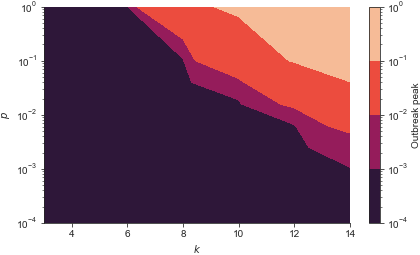

In [134]:
plt.figure(figsize=(w, 1./golden_ratio*w))
cs = plt.contourf(k_offblock, ps, peaks, levels=np.logspace(-4, 0, 5), norm=LogNorm())
# plt.clabel(cs, fmt='%1.0f')
plt.colorbar(cs, label='Outbreak peak')
plt.xlabel('$k$')
# plt.title('Outbreak peak (in % of tot. population)')
plt.ylabel('$p$')
plt.xlim(3, 14)
plt.ylim(1e-4, 1)
sns.despine()
plt.yscale('log')
# plt.savefig('contour_peak.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [ ]:
max_cuminfected = cum_infected[..., -1] / 1e6
std_max_cuminfected = std_cuminf[..., -1] / 1e6

In [ ]:
plt.figure(figsize=(w, 1./golden_ratio*w))
cs2 = plt.contourf(k_offblock, ps, max_cuminfected, levels=np.logspace(-4, 0, 5), norm=LogNorm())
plt.xlim(3, 14)
plt.ylim(1e-4, 1)
# plt.clabel(cs2, fmt='%1.0f')
plt.colorbar(cs2, label='Total infected')
plt.xlabel('$k$')
# plt.title('Total infected (in % of tot. population)')
plt.ylabel('$p$')
sns.despine()
plt.yscale('log')
# plt.savefig('contour_cuminf.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [101]:
w = figwidth
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(w, 1./golden_ratio*w), tight_layout=True)
axs[0].contourf(k_offblock, ps, peaks * 100, cmap='inferno', levels=[0, 1, 5, 10, 15, 20, 25, 30, 35])
# plt.clabel(cs, fmt='%1.0f')
plt.colorbar(cs, label='Outbreak peak (% of population)')
plt.xlabel('$k$')
# plt.title('Outbreak peak (in % of tot. population)')
plt.ylabel('$p$')
plt.xlim(8)
plt.ylim(0, 0.1)
sns.despine()
axs[1].contourf(k_offblock, ps, (max_cuminfected * 100), cmap='inferno', levels=[0, 25, 50, 75, 100])
plt.xlim(8, 18)
plt.ylim(0, 0.1)
# plt.clabel(cs2, fmt='%1.0f')
plt.colorbar(cs2, label='Total infected (% of population)')
plt.xlabel('$k$')
# plt.title('Total infected (in % of tot. population)')
plt.ylabel('$p$')
sns.despine()

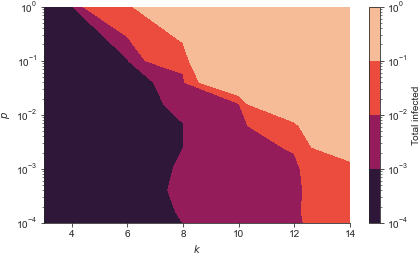

In [135]:
plt.figure(figsize=(w, 1./golden_ratio*w))
cs2 = plt.contourf(k_offblock, ps, max_cuminfected, levels=np.logspace(-4, 0, 5), norm=LogNorm())
plt.xlim(3, 14)
plt.ylim(1e-4, 1)
# plt.clabel(cs2, fmt='%1.0f')
plt.colorbar(cs2, label='Total infected')
plt.xlabel('$k$')
# plt.title('Total infected (in % of tot. population)')
plt.ylabel('$p$')
sns.despine()
plt.yscale('log')
# plt.savefig('contour_cuminf.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [ ]:
w = figwidth
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(w, 1./golden_ratio*w), tight_layout=True)
axs[0].contourf(k_offblock, ps, peaks * 100, cmap='inferno', levels=[0, 1, 5, 10, 15, 20, 25, 30, 35])
# plt.clabel(cs, fmt='%1.0f')
plt.colorbar(cs, label='Outbreak peak (% of population)')
plt.xlabel('$k$')
# plt.title('Outbreak peak (in % of tot. population)')
plt.ylabel('$p$')
plt.xlim(8)
plt.ylim(0, 0.1)
sns.despine()
axs[1].contourf(k_offblock, ps, (max_cuminfected * 100), cmap='inferno', levels=[0, 25, 50, 75, 100])
plt.xlim(8, 18)
plt.ylim(0, 0.1)
# plt.clabel(cs2, fmt='%1.0f')
plt.colorbar(cs2, label='Total infected (% of population)')
plt.xlabel('$k$')
# plt.title('Total infected (in % of tot. population)')
plt.ylabel('$p$')
sns.despine()

In [61]:
w = figwidth
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(w, 1./golden_ratio*w), tight_layout=True)
axs[0].contourf(k_offblock, ps, peaks * 100, cmap='inferno', levels=[0, 1, 5, 10, 15, 20, 25, 30, 35])
# plt.clabel(cs, fmt='%1.0f')
plt.colorbar(cs, label='Outbreak peak (% of population)')
plt.xlabel('$k$')
# plt.title('Outbreak peak (in % of tot. population)')
plt.ylabel('$p$')
plt.xlim(8)
plt.ylim(0, 0.1)
sns.despine()
axs[1].contourf(k_offblock, ps, (max_cuminfected * 100), cmap='inferno', levels=[0, 25, 50, 75, 100])
plt.xlim(8, 18)
plt.ylim(0, 0.1)
# plt.clabel(cs2, fmt='%1.0f')
plt.colorbar(cs2, label='Total infected (% of population)')
plt.xlabel('$k$')
# plt.title('Total infected (in % of tot. population)')
plt.ylabel('$p$')
sns.despine()

C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\simon\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\simon\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


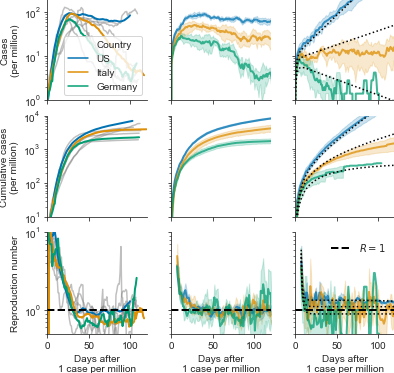

In [149]:
ks_clustered = [14, 12, 10]
w = figwidth
fig, axs = plt.subplots(nrows=3, ncols=3, sharey='row', sharex=True, figsize=(w, 1.6/golden_ratio*w), gridspec_kw={'hspace': 0.15,
                                                                                                                 'wspace': 0.25},
                       tight_layout=True)
### real data
plt.sca(axs[0][0])
# plt.title('Cases (per mil)')
sns.lineplot(data=df.loc[df['Country/Region'].isin(coloredcountries)], x='Shifted Date pm', linewidth=2, palette='colorblind',
            y='Mean new cases pm', hue='Country', hue_order=coloredcountries, estimator=sum, ci=None, legend='brief')
sns.lineplot(data=df.loc[df['Country/Region'].isin(graycountries)], x='Shifted Date pm', palette=['Gray']*len(interesting_countries[3:]),
            alpha=0.5, y='Mean new cases pm', hue='Country', hue_order=graycountries, estimator=sum, ci=None, legend=False, zorder=-1)
plt.ylim(1, 2e2)
plt.ylabel('')
plt.ylabel('Cases\n(per million)')
plt.yscale('log')
sns.despine()


plt.sca(axs[1][0])
# plt.title('Cumulative cases (per mil)')
sns.lineplot(data=df.loc[df['Country/Region'].isin(coloredcountries)], x='Shifted Date pm', y='Confirmed pm', linewidth=2, palette='colorblind',
            hue='Country', hue_order=coloredcountries, estimator=sum, ci=None, legend=False)
sns.lineplot(data=df.loc[df['Country/Region'].isin(graycountries)], x='Shifted Date pm', palette=['Gray']*len(interesting_countries[3:]),
            alpha=0.5, y='Confirmed pm', hue='Country', hue_order=graycountries, estimator=sum, ci=None, legend=False, zorder=-1)
plt.ylabel('Cumulative cases\n(per million)')
# plt.ylabel('')
plt.ylim(1e1, 1e4)
plt.yscale('log')
sns.despine()


plt.sca(axs[2][0])
sns.lineplot(data=df.loc[df['Country/Region'].isin(coloredcountries)], x='Shifted Date pm', y='R', linewidth=2, palette='colorblind',
            hue='Country', hue_order=coloredcountries, estimator=sum, ci=None, legend=False)
sns.lineplot(data=df.loc[df['Country/Region'].isin(graycountries)], x='Shifted Date pm', palette=['Gray']*len(interesting_countries[3:]),
            alpha=0.5, y='R', hue='Country', hue_order=graycountries, estimator=sum, ci=None, legend=False, zorder=-1)
plt.xlim(0, 120)
plt.ylim(0.5, 10)
plt.plot([0, 200], [1, 1], 'k--', label='R = 1', lw=2)
plt.yscale('log')
plt.ylabel('Reproduction number')
plt.xlabel('Days after\n1 case per million')
# plt.ylabel('')

### clustered graph ###
ind = 2
plt.sca(axs[0][1])
sns.despine()
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks_clustered)], hue='k', x='Shifted t', y='Rolling new cases',
             palette='colorblind', hue_order=ks_clustered, # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
sns.despine()


plt.sca(axs[1][1])
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks_clustered)], hue='k', x='Shifted t', y='Cumulative cases',
             palette='colorblind', hue_order=ks_clustered,# style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
# plt.ylabel('')
sns.despine()


plt.sca(axs[2][1])
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks_clustered)], hue='k', x='Shifted t', y='R',
             palette='colorblind', hue_order=ks_clustered,# style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)

plt.plot([0, 200], [1, 1], 'k--', label='R = 1', lw=2)
plt.xlabel('Days after\n1 case per million')
sns.despine()
plt.tight_layout()

### random graph ###
ind = -1
plt.sca(axs[0][2])
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks)], hue='k', x='Shifted t',
             y='Rolling new cases', hue_order=ks,
             palette='colorblind', # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
for sol in sols:
    plt.plot(sol[0], sol[1], 'k:')
sns.despine()

plt.sca(axs[1][2])
# plt.title('Cumulative cases (per mil)')
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks)], hue='k', x='Shifted t',
             y='Cumulative cases', hue_order=ks,
             palette='colorblind', # style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)
for sol in sols:
    plt.plot(sol[0], sol[2], 'k:')
sns.despine()


plt.sca(axs[2][2])
sns.lineplot(data=dfsim.loc[dfsim.p == ps[ind]].loc[dfsim.k.isin(ks)], hue='k', x='Shifted t', y='R',
             palette='colorblind', hue_order=ks,# style='n',
             alpha=0.75, markers=False, dashes=False, legend=False, linewidth=2)

plt.plot([0, 200], [1, 1], 'k--', label='$R = 1$', lw=2)
for sol in sols:
    plt.plot(sol[0], sol[3], 'k:')
plt.xlabel('Days after\n1 case per million')
plt.legend(loc='upper right', frameon=False)
sns.despine()

# plt.savefig('figures\\Fig1.svg', bbox_inches='tight', pad_inches=0)

In [71]:
mean_infected = n_prnew[..., 2].mean(axreps)
std_infected = n_prnew[..., 2].std(axreps, ddof=1) / np.sqrt(reps)  # std of the mean of infected

mean_recovered = n_prnew[..., -1].mean(axreps)
std_recovered = n_prnew[..., -1].std(axreps, ddof=1) / np.sqrt(reps)
cum_infected = mean_recovered + mean_infected
std_cuminf = np.sqrt(std_recovered**2 + std_infected**2)

newcases = np.zeros_like(cum_infected)
newcases[..., 1:] = cum_infected[..., 1:] - cum_infected[..., :-1]
std_newcases = np.zeros_like(newcases)
std_newcases[..., 1:] = np.sqrt(std_cuminf[..., 1:]**2 + std_cuminf[..., :-1]**2)
r_eff = np.zeros_like(mean_infected)
r_eff[..., t_lag:] = np.divide(newcases[..., t_lag:], newcases[..., :-t_lag], where=newcases[..., :-t_lag]>0,
                               out=np.zeros_like(r_eff[..., t_lag:]))
# r_eff = np.ma.array(r_eff, mask=(newcases[..., :-t_lag]==0))
std_r = np.zeros_like(r_eff)
std_r[..., t_lag:] = np.sqrt((std_newcases[..., t_lag:] / newcases[..., :-t_lag])**2 + (newcases[..., t_lag:] / newcases[..., :-t_lag]**2 *
                                                                      std_newcases[..., :-t_lag])**2)

peaks = mean_infected.max(axis=-1) / 1e6
argpeaks = mean_infected.argmax(axis=-1)
std_peaks = np.take_along_axis(std_infected, np.expand_dims(argpeaks, axis=-1), axis=-1).squeeze(axis=-1) / 1e6
max_cuminfected = cum_infected[..., -1] / 1e6
std_max_cuminfected = std_cuminf[..., -1] / 1e6

C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


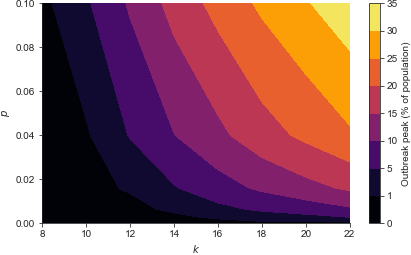

In [207]:
plt.figure(figsize=(w, 1./golden_ratio*w))
cs = plt.contourf(k_offblock, ps, peaks * 100, cmap='inferno', levels=[0, 1, 5, 10, 15, 20, 25, 30, 35])
# plt.clabel(cs, fmt='%1.0f')
plt.colorbar(cs, label='Outbreak peak (% of population)')
plt.xlabel('$k$')
# plt.title('Outbreak peak (in % of tot. population)')
plt.ylabel('$p$')
plt.xlim(8)
plt.ylim(0, 0.1)
sns.despine()
# plt.yscale('log')
plt.savefig('contour_peak.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [96]:
max_cuminfected = cum_infected[..., -1] / 1e6
std_max_cuminfected = std_cuminf[..., -1] / 1e6

In [185]:
%matplotlib inline

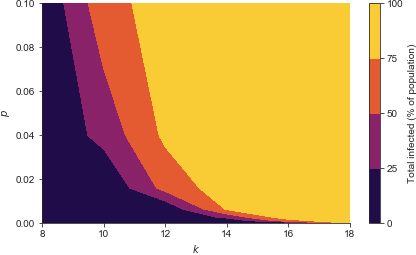

In [206]:
plt.figure(figsize=(w, 1./golden_ratio*w))
cs2 = plt.contourf(k_offblock, ps, (max_cuminfected * 100), cmap='inferno', levels=[0, 25, 50, 75, 100])
plt.xlim(8, 18)
plt.ylim(0, 0.1)
# plt.clabel(cs2, fmt='%1.0f')
plt.colorbar(cs2, label='Total infected (% of population)')
plt.xlabel('$k$')
# plt.title('Total infected (in % of tot. population)')
plt.ylabel('$p$')
sns.despine()
# plt.yscale('log')
plt.savefig('contour_cuminf.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

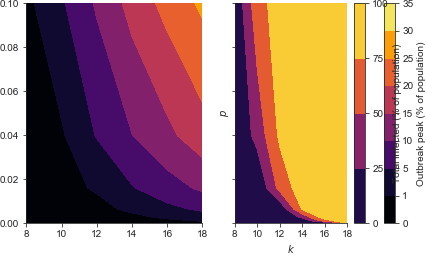

In [201]:
w = figwidth
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(w, 1./golden_ratio*w), tight_layout=True)
axs[0].contourf(k_offblock, ps, peaks * 100, cmap='inferno', levels=[0, 1, 5, 10, 15, 20, 25, 30, 35])
# plt.clabel(cs, fmt='%1.0f')
plt.colorbar(cs, label='Outbreak peak (% of population)')
plt.xlabel('$k$')
# plt.title('Outbreak peak (in % of tot. population)')
plt.ylabel('$p$')
plt.xlim(8)
plt.ylim(0, 0.1)
sns.despine()
axs[1].contourf(k_offblock, ps, (max_cuminfected * 100), cmap='inferno', levels=[0, 25, 50, 75, 100])
plt.xlim(8, 18)
plt.ylim(0, 0.1)
# plt.clabel(cs2, fmt='%1.0f')
plt.colorbar(cs2, label='Total infected (% of population)')
plt.xlabel('$k$')
# plt.title('Total infected (in % of tot. population)')
plt.ylabel('$p$')
sns.despine()